In [7]:
import string

import dask.diagnostics
import cycler
import fsspec
import numpy as np
import proplot
import vcm.catalog
import xarray as xr

import cloud
import generate_training_dataset
import plotting
import times

In [8]:
plotting.configure_style()

In [9]:
TEST_TIMES_FILE = "../workflows/ml-training/test.json"
test_times = times.open_times(TEST_TIMES_FILE)

In [10]:
NUDGED_SIMULATIONS = {
    "Minus 4 K": "gs://vcm-ml-experiments/spencerc/2022-01-19/n2f-25km-minus-4k-snoalb/fv3gfs_run",
    "Unperturbed": "gs://vcm-ml-experiments/spencerc/2022-01-19/n2f-25km-unperturbed-snoalb/fv3gfs_run",
    "Plus 4 K": "gs://vcm-ml-experiments/spencerc/2022-01-19/n2f-25km-plus-4k-snoalb/fv3gfs_run",
    "Plus 8 K": "gs://vcm-ml-experiments/spencerc/2022-01-19/n2f-25km-plus-8k-snoalb/fv3gfs_run"
}
CLIMATES = ["Minus 4 K", "Unperturbed", "Plus 4 K", "Plus 8 K"]

In [11]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()
state = cloud.open_tape_sequence(NUDGED_SIMULATIONS, "state_after_timestep").sel(time=test_times)
tendencies = cloud.open_tape_sequence(NUDGED_SIMULATIONS, "nudging_tendencies").sel(time=test_times)
ds = xr.merge([state, tendencies])

In [12]:
VARIABLES = [
    "air_temperature_tendency_due_to_nudging",
    "specific_humidity_tendency_due_to_nudging",
    "pressure_thickness_of_atmospheric_layer"
]

ds = ds[VARIABLES].sel(climate=CLIMATES)

In [13]:
scale_factor = generate_training_dataset.nudging_tendency_scale_factor(ds.z)

In [14]:
NUDGING_TENDENCY_VARIABLES = [
    "air_temperature_tendency_due_to_nudging",
    "specific_humidity_tendency_due_to_nudging"
]
nudging_tendencies = ds[NUDGING_TENDENCY_VARIABLES]
tapered_nudging_tendencies = scale_factor * nudging_tendencies

In [15]:
interpolated = vcm.interpolate_to_pressure_levels(tapered_nudging_tendencies, ds.pressure_thickness_of_atmospheric_layer, dim="z")
mean_profile = interpolated.weighted(grid.area).mean(["x", "y", "tile"]).mean("time")
vertically_integrated = (tapered_nudging_tendencies * ds.pressure_thickness_of_atmospheric_layer).sum("z").mean("time") / 9.81

In [16]:
with dask.diagnostics.ProgressBar():
    mean_profile = mean_profile.compute()
    vertically_integrated = vertically_integrated.compute()

[#######                                 ] | 18% Completed |  2min 10.7s

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 14min  7.3s
[########################################] | 100% Completed | 10min 44.8s


In [17]:
Cv = 717.0
SECONDS_PER_DAY = 86400
G_PER_KG = 1000
heating = (Cv * vertically_integrated.air_temperature_tendency_due_to_nudging).to_dataset()
moistening = (SECONDS_PER_DAY * vertically_integrated.specific_humidity_tendency_due_to_nudging).to_dataset()

In [20]:
mean_heating = heating.weighted(grid.area).mean(["x", "y", "tile"]).sel(climate="Unperturbed").compute().air_temperature_tendency_due_to_nudging.item()
mean_moistening = moistening.weighted(grid.area).mean(["x", "y", "tile"]).sel(climate="Unperturbed").compute().specific_humidity_tendency_due_to_nudging.item()

In [21]:
WONG_PALETTE = [
    "#56B4E9",
    "#E69F00",
    "#009E73",
    "#0072B2",
    "#D55E00",
    "#CC79A7",
    "#F0E442"
]
proplot.rc["axes.prop_cycle"] = cycler.cycler("color", WONG_PALETTE)

In [22]:
mean_profile = mean_profile.assign_coords(pressure=mean_profile.pressure / 100)

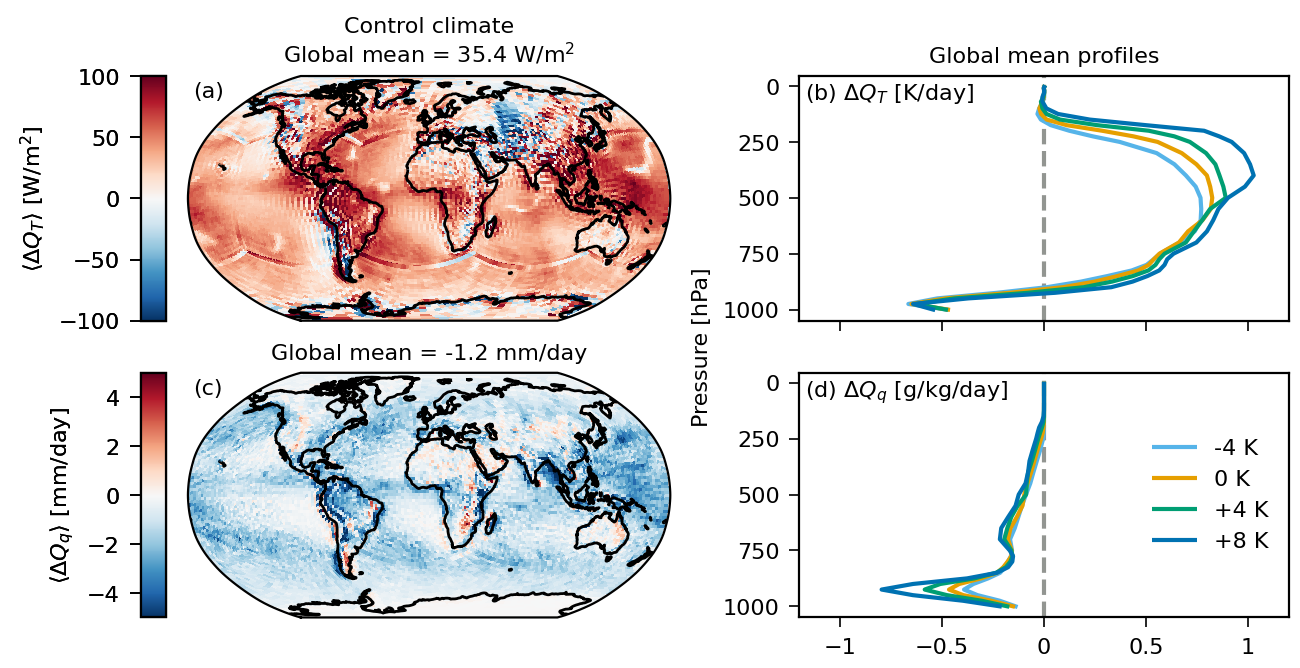

In [33]:
fig, (ax1, ax2, ax3, ax4) = proplot.subplots(
    ncols=2,
    nrows=2,
    projection=["robin", None, "robin", None],
    figwidth=6.5,
    refaspect=2.0,
    sharey="labels",
    sharex=True
)

p1 = plotting.plot_map(
    ax1,
    heating.sel(climate="Unperturbed"),
    "air_temperature_tendency_due_to_nudging",
    -100,
    100,
    discrete=False
)

p2 = plotting.plot_map(
    ax3,
    moistening.sel(climate="Unperturbed"),
    "specific_humidity_tendency_due_to_nudging",
    -5,
    5,
    discrete=False
)

dQ1_handles = (SECONDS_PER_DAY * mean_profile.air_temperature_tendency_due_to_nudging).plot(
    ax=ax2,
    hue="climate",
    y="pressure",
    yincrease=False,
    add_legend=False
)

dQ2_handles = (SECONDS_PER_DAY * G_PER_KG * mean_profile.specific_humidity_tendency_due_to_nudging).plot(
    ax=ax4,
    hue="climate",
    y="pressure",
    yincrease=False,
    add_legend=False
)

ax2.set_ylabel("Pressure [hPa]")
ax4.set_ylabel("Pressure [hPa]")
ax2.set_xlabel("")
ax4.set_xlabel("")
ax2.set_title("Global mean profiles")
ax2.set_xlim([-1.2, 1.2])
ax4.set_xlim([-1.2, 1.2])
ax2.axvline(0, color="Gray", ls="--", zorder=0)
ax4.axvline(0, color="Gray", ls="--", zorder=0)

fig.colorbar(
    p1,
    loc="left",
    label="$\\left<\Delta Q_T\\right>$ [W/m$^2$]",
    rows=[1],
    width=0.125,
    ticks=np.arange(-100, 101, 50)
)
fig.colorbar(
    p2,
    loc="left",
    label="$\\left<\Delta Q_q\\right>$ [mm/day]",
    rows=[2],
    width=0.125
)

ax4.legend(
    dQ2_handles,
    ["-4 K", "0 K", "+4 K", "+8 K"],
    ncols=1,
    fontsize=8,
    loc="center right",
    frameon=False
)

ax1.set_title(f"Control climate\nGlobal mean = {mean_heating:0.1f} W/m$^2$")
ax3.set_title(f"Global mean = {mean_moistening:0.1f} mm/day")

ax1.annotate(
    "(a)",
    xy=(0, 1),
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax2.annotate(
    "(b) $\Delta Q_T$ [K/day]",
    xy=(0, 1),
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax3.annotate(
    "(c)",
    xy=(0, 1),
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax4.annotate(
    "(d) $\Delta Q_q$ [g/kg/day]",
    xy=(0, 1),
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)

fig.savefig("figures/figure-04.png", dpi=200)
fig.savefig("figures/figure-04.pdf")